## Importar librerias y definición de la ruta  de trabajo (path)

In [1]:

import pandas as pd
import numpy as np
import os
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

# Tratamiento de datos
# ==============================================================================
import shap
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import TimeSeriesFold
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
import skforecast
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import sklearn
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================


# Configuración warnings
# ==============================================================================
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

# Formato de los prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def headr(text):
    return ('\n'+color.UNDERLINE + text + color.END+'\n')


Versión skforecast: 0.15.1
Versión scikit-learn: 1.6.1
Versión pandas: 2.2.3
Versión numpy: 1.26.4


In [2]:
# Ingresa la ruta donde está el repositorio
ruta = 'c:/repo_remoto/'

## Preprocesado

In [3]:
mantenimiento_df = pd.read_csv(ruta + 'Etapa4/output/merge_df.csv')

In [4]:
equipo = 2  # Introduce el equipo a procesar
mantenimiento_df_1 = mantenimiento_df[mantenimiento_df['ID_Equipo'] == equipo].copy()
mantenimiento_df_1

,Fecha,ID_Equipo,Tipo_Mantenimiento,Ubicacion,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
1,2021-01-01,2,Preventivo,Ubicacion_A,46.619128,5.462178,219,Compresor,Fabricante_B,Modelo_3,495,550
501,2021-01-02,2,Preventivo,Ubicacion_A,27.325772,2.169030,241,Compresor,Fabricante_B,Modelo_3,495,550
1001,2021-01-03,2,Preventivo,Ubicacion_A,59.782044,2.766126,249,Compresor,Fabricante_B,Modelo_3,495,550
1501,2021-01-04,2,Preventivo,Ubicacion_A,28.018631,9.115977,260,Compresor,Fabricante_B,Modelo_3,495,550
2001,2021-01-05,2,Preventivo,Ubicacion_A,60.604635,7.734923,272,Compresor,Fabricante_B,Modelo_3,495,550
...,...,...,...,...,...,...,...,...,...,...,...,...
729248,2024-12-27,2,Preventivo,Ubicacion_A,47.881532,9.801241,139,Compresor,Fabricante_B,Modelo_3,495,550
729748,2024-12-28,2,Preventivo,Ubicacion_A,31.870169,5.820973,156,Compresor,Fabricante_B,Modelo_3,495,550
730248,2024-12-29,2,Preventivo,Ubicacion_A,47.672791,3.379649,170,Compresor,Fabricante_B,Modelo_3,495,550
730748,2024-12-30,2,Preventivo,Ubicacion_A,44.255879,3.194149,179,Compresor,Fabricante_B,Modelo_3,495,550


In [5]:
mantenimiento_df_1['Fecha'] = pd.to_datetime(mantenimiento_df_1['Fecha'], format='%Y-%m-%d')
mantenimiento_df_1 = mantenimiento_df_1.set_index('Fecha')

In [6]:
# Eliminar duplicados en el índice para evitar errores
mantenimiento_df_1 = mantenimiento_df_1[~mantenimiento_df_1.index.duplicated(keep='first')]

mantenimiento_df_1 = mantenimiento_df_1.asfreq('D')  # Convierte Timeseries a frecuencia especificada.
mantenimiento_df_1 = mantenimiento_df_1.sort_index()

In [7]:
# Sumatorio de filas duplicadas en mantenimiento_df
print("Sumatorio de filas duplicadas en mantenimiento_df:", mantenimiento_df_1.duplicated().sum())

Sumatorio de filas duplicadas en mantenimiento_df: 0


In [8]:
print(f'Número de filas con missing values: {mantenimiento_df_1.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [9]:
# Verificar que un índice temporal está completo

fecha_inicio = mantenimiento_df_1.index.min()
fecha_fin = mantenimiento_df_1.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=mantenimiento_df_1.index.freq)

print(f"Índice completo: {(mantenimiento_df_1.index == date_range_completo).all()}")

Índice completo: True


In [10]:
mantenimiento_df_1

,ID_Equipo,Tipo_Mantenimiento,Ubicacion,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,,,,,,
2021-01-01,2,Preventivo,Ubicacion_A,46.619128,5.462178,219,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-02,2,Preventivo,Ubicacion_A,27.325772,2.169030,241,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-03,2,Preventivo,Ubicacion_A,59.782044,2.766126,249,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-04,2,Preventivo,Ubicacion_A,28.018631,9.115977,260,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-05,2,Preventivo,Ubicacion_A,60.604635,7.734923,272,Compresor,Fabricante_B,Modelo_3,495,550
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,2,Preventivo,Ubicacion_A,47.881532,9.801241,139,Compresor,Fabricante_B,Modelo_3,495,550
2024-12-28,2,Preventivo,Ubicacion_A,31.870169,5.820973,156,Compresor,Fabricante_B,Modelo_3,495,550
2024-12-29,2,Preventivo,Ubicacion_A,47.672791,3.379649,170,Compresor,Fabricante_B,Modelo_3,495,550


In [11]:
# Elimino ID_Orden, establezco Fecha como índice y le doy formato datetime
mantenimiento_df_1 = mantenimiento_df_1.drop(
    columns=['ID_Equipo','Ubicacion', 'Tipo_Equipo', 'Fabricante', 'Modelo', 'Potencia_kW', 'Horas_Recomendadas_Revision'])

In [77]:
mantenimiento_df_1

,Tipo_Mantenimiento,Temperatura_C,Vibracion_mm_s,Horas_Operativas
Fecha,,,,
2021-01-01,Preventivo,46.619128,5.462178,219
2021-01-02,Preventivo,27.325772,2.169030,241
2021-01-03,Preventivo,59.782044,2.766126,249
2021-01-04,Preventivo,28.018631,9.115977,260
2021-01-05,Preventivo,60.604635,7.734923,272
...,...,...,...,...
2024-12-27,Preventivo,47.881532,9.801241,139
2024-12-28,Preventivo,31.870169,5.820973,156
2024-12-29,Preventivo,47.672791,3.379649,170


In [12]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador para la columna Tipo_Mantenimiento
label_encoder = LabelEncoder()

# Transformar la columna Tipo_Mantenimiento en valores numéricos
mantenimiento_df_1['Tipo_Mantenimiento'] = label_encoder.fit_transform(mantenimiento_df_1['Tipo_Mantenimiento'])

# Verificar la transformación
mantenimiento_df_1

,Tipo_Mantenimiento,Temperatura_C,Vibracion_mm_s,Horas_Operativas
Fecha,,,,
2021-01-01,1,46.619128,5.462178,219
2021-01-02,1,27.325772,2.169030,241
2021-01-03,1,59.782044,2.766126,249
2021-01-04,1,28.018631,9.115977,260
2021-01-05,1,60.604635,7.734923,272
...,...,...,...,...
2024-12-27,1,47.881532,9.801241,139
2024-12-28,1,31.870169,5.820973,156
2024-12-29,1,47.672791,3.379649,170


Fechas train : 2021-01-01 00:00:00 --- 2024-09-22 00:00:00  (n=1361)
Fechas test  : 2024-09-23 00:00:00 --- 2024-12-31 00:00:00  (n=100)


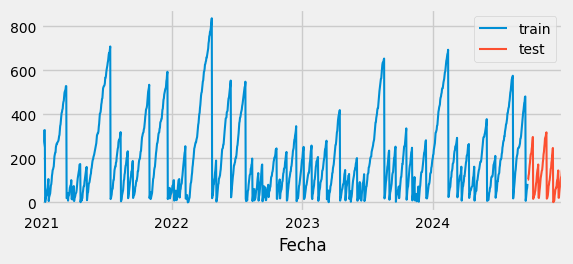

In [13]:
# Separación datos train-test

steps = 100
datos_train = mantenimiento_df_1[:-steps]
datos_test  = mantenimiento_df_1[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend();

In [14]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=470
    )

exogs_train = datos_train.drop(columns=['Horas_Operativas'])

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432
 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468
 469 470] 
Window features: None 
Window size: 470 
Exogenous included: True 
Exogenous names: Tipo_Mantenimiento, Temperatura_C, Vibracion_mm_s 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-09-22 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-26 19:09:08 
Last fit date: 2025-04-26 19:09:28 
Skforecast version: 0.15.1 
Python version: 3.10.11 
Forecaster id: None

In [15]:
# Predicciones

exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
predicciones.head(15)

2024-09-23     94.69
2024-09-24    106.97
2024-09-25    122.12
2024-09-26    134.34
2024-09-27    151.03
2024-09-28    165.83
2024-09-29    177.28
2024-09-30    188.63
2024-10-01    205.10
2024-10-02    218.76
2024-10-03    236.06
2024-10-04    245.44
2024-10-05    255.52
2024-10-06    258.51
2024-10-07    269.88
Freq: D, Name: pred, dtype: float64

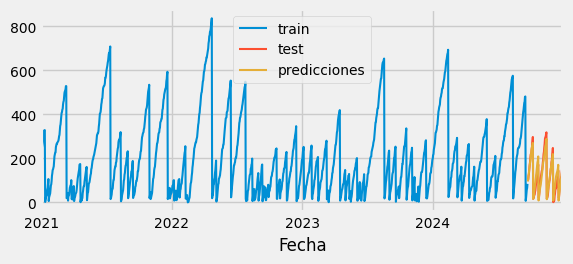

In [16]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [17]:
# Error test
error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

# Varianza de los valores reales
varianza = datos_test['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza de los valores reales: {varianza}")

Error de test (mse): 565.501517
Varianza de los valores reales: 6979.852929292931


In [19]:
# Specify the step for which you want to calculate feature importances
step = 1  # Replace with the desired step number
importancia = forecaster.get_feature_importances()
importancia

,feature,importance
0,lag_1,0.797636
470,Tipo_Mantenimiento,0.120419
1,lag_2,0.019484
3,lag_4,0.009162
2,lag_3,0.008682
...,...,...
379,lag_380,0.000002
162,lag_163,0.000002
324,lag_325,0.000002
261,lag_262,0.000001


In [ ]:
# Búsqueda de hiperparámetros

from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=470  # Este valor será remplazado en el grid search
)

cv = TimeSeriesFold(
    steps=15,
    initial_train_size=int(len(datos_train) * 0.5),
    fixed_train_size=False,
    refit=False,
)

param_grid = {'n_estimators': np.arange(10, 201, 50),     # Valid range of integers for n_estimators
              'max_depth': [3, 5, 10]
}

lags_grid = [470, 500]

resultados_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    param_grid=param_grid,
    lags_grid=lags_grid,
    metric='mean_squared_error',
    return_best=True,
    n_jobs='auto',
    verbose=False
)

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [282]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(n_estimators=110,random_state=123),
    lags=470
    )

exogs_train = datos_train.drop(columns=['Horas_Operativas'])

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432
 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468
 469 470] 
Window features: None 
Window size: 470 
Exogenous included: True 
Exogenous names: Tipo_Mantenimiento, Temperatura_C, Vibracion_mm_s 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 110,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-25 10:34:23 
Last fit date: 2025-04-25 10:34:44 
Skforecast version: 0.15.1 
Python version: 3.10.11 
Forecaster id: None

In [20]:
# Predicciones

exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
predicciones.head(5)

2024-09-23     94.69
2024-09-24    106.97
2024-09-25    122.12
2024-09-26    134.34
2024-09-27    151.03
Freq: D, Name: pred, dtype: float64

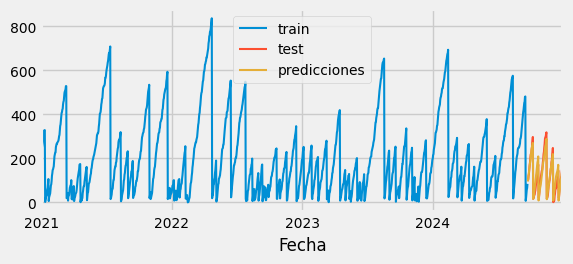

In [21]:
# Predicciones

exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)


# Gráfico predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [22]:
# Error test
error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

# Varianza de los valores reales
varianza = datos_test['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza de los valores reales: {varianza}")

Error de test (mse): 565.501517
Varianza de los valores reales: 6979.852929292931


In [48]:
# Backtesting

cv = TimeSeriesFold(
    steps=15,
    initial_train_size=int(len(mantenimiento_df_1) * 0.5),
    fixed_train_size=False,
    refit=True,
)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=mantenimiento_df_1['Horas_Operativas'],
    cv=cv,
    metric='mean_squared_error',
    verbose=True
)
metrica

Information of folds
--------------------
Number of observations used for initial training: 730
Number of observations used for backtesting: 731
    Number of folds: 49
    Number skipped folds: 0 
    Number of steps per fold: 15
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 11 observations.

Fold: 0
    Training:   2021-01-01 00:00:00 -- 2022-12-31 00:00:00  (n=730)
    Validation: 2023-01-01 00:00:00 -- 2023-01-15 00:00:00  (n=15)
Fold: 1
    Training:   2021-01-01 00:00:00 -- 2023-01-15 00:00:00  (n=745)
    Validation: 2023-01-16 00:00:00 -- 2023-01-30 00:00:00  (n=15)
Fold: 2
    Training:   2021-01-01 00:00:00 -- 2023-01-30 00:00:00  (n=760)
    Validation: 2023-01-31 00:00:00 -- 2023-02-14 00:00:00  (n=15)
Fold: 3
    Training:   2021-01-01 00:00:00 -- 2023-02-14 00:00:00  (n=775)
    Validation: 2023-02-15 00:00:00 -- 2023-03-01 00:00:00  (n=15)
Fold: 4
    Training:   2021-01-01 00:00:00 -- 2023-03

  0%|          | 0/49 [00:00<?, ?it/s]

,mean_squared_error
0,22276.51686


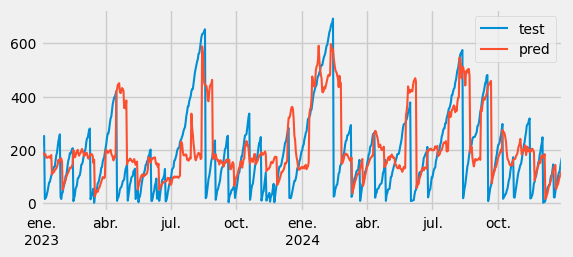

In [49]:
# Gráfico de predicciones de backtest vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
mantenimiento_df_1.loc[predicciones_backtest.index, 'Horas_Operativas'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend()